In [2]:
import warnings, time, gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=Warning)
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# from sklearn.utils import shuffle
from scipy.stats import rankdata
import visuals as vs
import matplotlib.pyplot as plt
%matplotlib inline
RANDOM = 47

In [3]:
data = pd.read_csv("census.csv")
data.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [4]:
'Percentage of income ">50K": {:.2f}'.format(100*data[data.income == '>50K'].shape[0]/data.shape[0])

'Percentage of income ">50K": 24.78'

In [5]:
data['income'] = pd.get_dummies(data['income'])['>50K']

In [6]:
cat_features = [col for col in data.columns if data[col].dtype == 'object']
target_encoding = dict.fromkeys(cat_features, 0)

for feature in cat_features:
    cat_ = data[feature].dropna().unique()
    ones_percentage = []
    for k, v in enumerate(cat_):
        zeros = data[(data[feature] == v) & (data.income == 0)].shape[0]
        ones = data[(data[feature] == v) & (data.income == 1)].shape[0]
        ones_percentage.append(100 * (ones/(ones + zeros)))
    feature_map = {key:value for (key, value) in zip(cat_, ones_percentage)}
    target_encoding[feature] = feature_map

In [7]:
data_ = data.loc[:, cat_features].copy()
for feat in target_encoding:
    data_[feat].replace(target_encoding[feat], inplace=True)
data_.columns = [col+'_x' for col in data_.columns]

In [8]:
for feat in cat_features:
    data[feat] = rankdata(data[feat], method='dense')

In [9]:
data = data.merge(data_, right_index=True, left_index=True)
data = pd.get_dummies(data)

In [10]:
y_train = data['income']
X_train = data.drop('income', axis = 1)
y_train = y_train.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=RANDOM)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


In [11]:
warnings.filterwarnings(action='ignore', category=Warning)

In [12]:
# ref: https://gist.github.com/groverpr/bb937d1db98c2bfb2e7eca1765e64bdf
def f_beta_wrapper(y_true, y_pred):
    beta = 0.5
    return 'custom_eval_metric', fbeta_score(np.array((y_pred > 0.4).astype(int)), y_true, beta), True

In [13]:
# Calculate accuracy, precision and recall
TP = np.sum(y_train)
FP = y_train.count() - TP
TN = 0
FN = 0 
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

fscore = (1 + (0.5**2)) * (precision * recall) / ((0.5**2) * precision + recall)
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2468, F-score: 0.2906]


In [14]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    start = time.time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time.time()
    results['train_time'] = end - start
    start = time.time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time.time()
    results['pred_time'] = end - start
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    return results

AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LGBMClassifier trained on 361 samples.
LGBMClassifier trained on 3617 samples.
LGBMClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


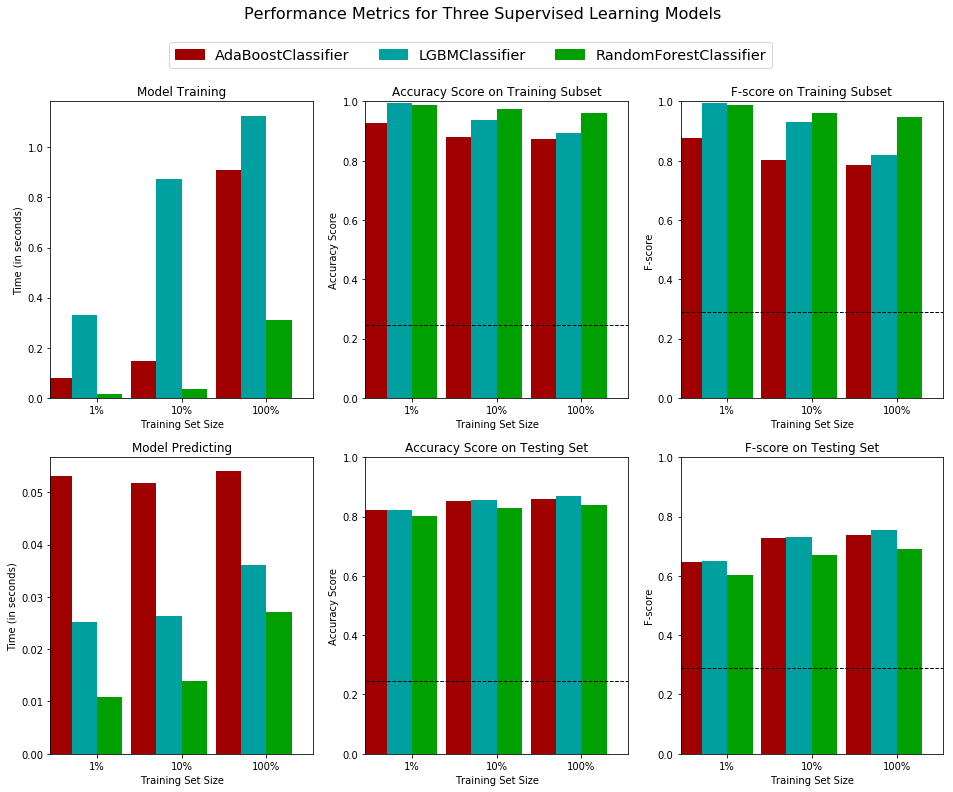

In [15]:
clf_A = AdaBoostClassifier(random_state=RANDOM)
clf_B = LGBMClassifier(random_state=RANDOM)
clf_C = RandomForestClassifier(random_state=RANDOM)

samples_100 = len(y_train)
samples_10 = len(y_train)//10
samples_1 = len(y_train)//100

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

vs.evaluate(results, accuracy, fscore)

In [16]:
start = time.time()
clf = LGBMClassifier(class_weight={0: 1.9}, random_state=RANDOM, silent=False, verbose=-1)

parameters = {
              'max_depth':[7, 8, 9],
              'learning_rate': [0.1, 0.15, 0.2],
              'n_estimators': [100, 500],
             }
              
scorer = make_scorer(fbeta_score, beta=0.5)
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, n_jobs = 1, cv = 10)
grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print('Run time: {:.2f}mins'.format((time.time() - start)/60))

Unoptimized model
------
Accuracy score on testing data: 0.8631
F-score on testing data: 0.7725

Optimized Model
------
Final accuracy score on the testing data: 0.8650
Final F-score on the testing data: 0.7754
Run time: 8.15mins


In [18]:
print(best_clf)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1.9},
        colsample_bytree=1.0, learning_rate=0.2, max_depth=7,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=47, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=-1)


In [19]:
print('=================== Start training LGBMClassifier ===================')
oof_pred = np.zeros(X_train.shape[0])
y_pred = np.zeros(X_test.shape[0])
folds = KFold(n_splits= 10, shuffle=True, random_state=RANDOM)
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    clf = LGBMClassifier(boosting_type='gbdt', class_weight={0: 1.9},
        colsample_bytree=1.0, learning_rate=0.2, max_depth=7,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=47, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=-1)
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],\
            eval_metric = f_beta_wrapper, early_stopping_rounds= 50, verbose=False)
    oof_pred[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)
    y_pred += clf.predict(X_test, num_iteration=clf.best_iteration_) / folds.n_splits

=================== Start training LGBMClassifier ===================


In [20]:
print('Full F-score score {:.6f}'.format(fbeta_score(y_train, oof_pred, beta=0.5)))

y_pred = pd.Series(y_pred).map(lambda x: 1 if x > 0.4 else 0)
print('\nFinal accuracy score on the testing data: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Final F-score on the testing data: {:.4f}'.\
      format(fbeta_score(y_test, np.array((y_pred > 0.4).astype(int)), beta = 0.5)))

Full F-score score 0.764491

Final accuracy score on the testing data: 0.8657
Final F-score on the testing data: 0.7775


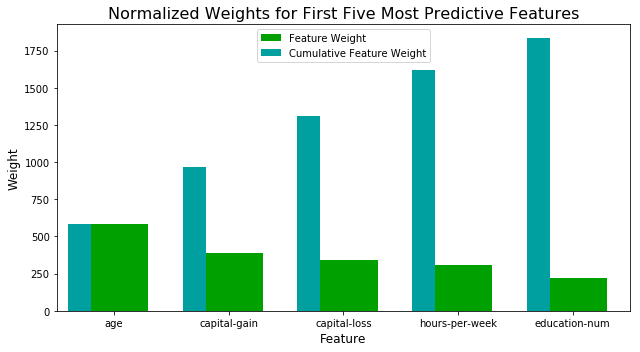

In [21]:
model = LGBMClassifier(random_state=RANDOM).fit(X_train, y_train)
importances = model.feature_importances_ 

vs.feature_plot(importances, X_train, y_train)

In [22]:
from sklearn.base import clone

X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

clf = (clone(best_clf)).fit(X_train_reduced, y_train)
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8650
F-score on testing data: 0.7754

Final Model trained on reduced data
------
Accuracy on testing data: 0.8337
F-score on testing data: 0.7125
